In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random
import copy

In [2]:
hbar = 1.05 * 10**(-34)
e = 1.6 * 10**(-19)
Phi0 = np.pi * hbar / e

# Objects

## Transmon

<img src="img/transmon.png" align="right" alt="Drawing" style="width: 400px;"/>

$E_{j1} = \cfrac{\hbar I_{j1}}{2e}$

$E_{j2} = \cfrac{\hbar I_{j2}}{2e}$ (если есть)

$\Phi_{ext} = MI$

$E_j = \sqrt{E_{j1}^2 + E_{j2}^2 + E_{j1}E_{j2}\cos(2e \Phi_{ext}/\hbar)}$

$E_c = \cfrac{e^2}{2(C + C_r + C_l + C_u)} = \cfrac{e^2}{2(C + C_{neighbours})}$

$\hbar \omega = \sqrt{(8 E_c E_j)}$

$E_{n-1, n} = \sqrt{(8 E_c E_j)} - E_cn$

In [3]:
class Transmon:
# properties
    # n - number of levels
    # psi - wave function
    # C capacity
    # Ej
    # Ec
    # w - array of freq 0-1, 1-2 ...
    # psi - wave function (defaulf [1, 0 , 0 ...])
    # gamma
    
    def __init__(self, psi, C, Ij1, Ij2 = 0, M = 0, I = 0, Cnb = [0], gamma = 0):
        
        # number of levels
        self.n = len(psi)
        
        #C, Ij1, Ij2, M, I, Cnb, Ej, Ec, w
        self.C = C
        self.Ij1 = Ij1
        self.Ij2 = Ij2
        self.M = M
        self.I = I
        self.Cnb = Cnb
        self.gamma = gamma
        
        Ej1 = hbar * Ij1 / (2 * e)
        Ej2 = hbar * Ij2 / (2 * e)
        Phiext = I * M
        self.Ej = np.sqrt(Ej1**2 + Ej2**2 + 2 * Ej1 * Ej2 * np.cos(2 * e / hbar * Phiext))
        self.Ec = e**2 / 2 / (C + np.sum(Cnb))
        self.w = np.zeros(self.n - 1)
        for i in range(1, self.n):
            self.w[i-1] = np.sqrt(8 * self.Ec * self.Ej) / hbar - self.Ec * i / hbar
            self.w[i-1] *= 10**(-9)

        
        #wave fucntion
        self.psi = np.array(psi, dtype = complex)
        if self.psi.size != self.n:
            print('error, wrong size of transmon.psi')
        self.psi = self.psi / np.linalg.norm(self.psi)
        self.psi.shape = (self.n, 1)

## Ocsillator

$\hbar \omega = \cfrac{\hbar}{\sqrt{L (C + C_{nb})}}$

$E_{n-1, n} = \hbar \omega$

In [33]:
class Oscillator:
# properties
    # n - number of levels
    # C - capacity
    # psi - wave function
    # w - array of freq 0-1, 1-2 ...
    # psi - wave function (defaulf [1, 0 , 0 ...])
    # gamma
    
    def __init__(self, psi, C, L, Cnb = [0], gamma = 0, noise = 0):
        
        # number of levels
        self.n = len(psi)
        
        #gamma, noise, L, С, w
        self.gamma = gamma
        self.noise = noise
        self.L = L
        self.C = C
        self.w = np.array([1/np.sqrt(L * (C + np.sum(Cnb)))] * (self.n - 1)) * 10**(-9)
        
        #wave fucntion
        self.psi = np.array(psi, dtype = complex)
        if self.psi.size != self.n:
            print('error, wrong size of oscillator.psi')
        self.psi = self.psi / np.linalg.norm(self.psi)
        self.psi.shape = (self.n, 1)

## Coupling

$G = \cfrac{C \sqrt{\omega_1\omega_2}}{2\sqrt{(C+C_1)(C+C_2)}}$

In [5]:
class Coupling():
    
    def __init__(self, C):
        self.C = C
        self.G = C / 2

## InSignal

накачка вида $\Omega(t) (a^\dagger + a)$

!!! не тот dc ток, который меняет частоту трансмона

In [6]:
class InSignal():

# drive
# cur
# change_freq 0 если обычная накачка, 1 если меняем частоту кубита
    
    def __init__(self, drive = np.array([]), change_freq = 0):
        self.drive = drive
        self.cur = 0
        self.change_freq = change_freq

## Circuit

In [36]:
# Для записи цепей. Цепь записывается через массив элементов цепи (вершины) и список ребер.
class Circuit():
    
# dt
# elements
# adjlist
# psi
# psiwrite
# a 
# ad
# H
# Hwrite
# HwriteRWB
    
    def __init__(self, elements, adjlist, dt):
        self.dt = dt
        self.elements = np.asarray(elements)
        self.adjlist = np.asarray(adjlist)
        self.psi, self.psiwrite = CreatePsi(self)
        
        # находим константы связи G
        for i in range(0, self.elements.size):
            if self.elements[i].__class__.__name__ == 'Coupling':
                self.elements[i].G = self.elements[i].C / 2
                tmp = self.adjlist[i][0]
                self.elements[i].G *= np.sqrt(self.elements[tmp].w[0]/(self.elements[i].C + self.elements[tmp].C))
                tmp = self.adjlist[i][1]
                self.elements[i].G *= np.sqrt(self.elements[tmp].w[0]/(self.elements[i].C + self.elements[tmp].C))
                
            if self.elements[i].__class__.__name__ == 'Transmon': #перерасчет частоты трансмона из-за сосдених емкостей
                Cnb = [0]
                for el in adjlist[i]:
                    if self.elements[el].__class__.__name__ == 'Coupling':
                        Cnb = np.append(Cnb, self.elements[el].C)
                self.elements[i] = Transmon(psi = self.elements[i].psi,\
                                            C = self.elements[i].C,\
                                            Ij1 = self.elements[i].Ij1,
                                            Ij2 = self.elements[i].Ij2,\
                                            M = self.elements[i].M,\
                                            I = self.elements[i].I,\
                                            Cnb = Cnb,\
                                            gamma = self.elements[i].gamma)
                
            if self.elements[i].__class__.__name__ == 'Oscillator': #перерасчет частоты резонатора из-за сосдених емкостей
                Cnb = [0]
                for el in adjlist[i]:
                    if self.elements[el].__class__.__name__ == 'Coupling':
                        Cnb = np.append(Cnb, self.elements[el].C)
                self.elements[i] = Oscillator(psi = self.elements[i].psi,\
                                              C = self.elements[i].C,\
                                              L = self.elements[i].L,\
                                              Cnb = Cnb,\
                                              gamma = self.elements[i].gamma,\
                                              noise = self.elements[i].noise)


        self.a, self.ad = CreateAAd(self)
        self.H = CreateHamiltonian(self)
        self.Hwrite, self.HwriteRWB = CreateHamiltonianWrite(self)
        self.rwb, self.rwbd = CreateRWB(self)
        
    def display_info(self):
        print(self.Hwrite)
        print(self.HwriteRWB)
        
    def upd_insignal(self, index, drive): #индекс InSignal в circuit и массив сигналов
        if self.elements[index].__class__.__name__ != 'InSignal':
            print('error, singnal is given not to InSignal vertice but to vertice ' + str(index) + ' '\
                  +  self.elements[index].__class__.__name__)
        else:
            self.elements[index].drive = np.asarray(drive)
            self.elements[index].cur = 0

# Operators (fuctions)

## CreatePsi

In [8]:
# волновая функиция по circuit 
def CreatePsi(circuit):
    psi = np.array([], dtype = complex)
    psiwrite = chr(936) + ' = '
    for i in range(0, circuit.elements.size):
        if 'psi' in circuit.elements[i].__dict__:
            if psi.size == 0:
                psi = circuit.elements[i].__dict__.get('psi')
                psiwrite = psiwrite + chr(936) + str(i)
            else:
                psi = np.kron(psi, circuit.elements[i].__dict__.get('psi'))
                psiwrite = psiwrite + chr(8855) + chr(936) + str(i)
    return(psi, psiwrite)

## CreateAAd

In [9]:
# операторы рождения и уничтожения по circuit
# RWB = 0. - не учитывается RWB
# RWB = 1. - учитывается (1 число шагов по времени)
def CreateAAd(circuit):
    n = circuit.psi.size
    a = np.stack([np.identity(n, dtype = complex)] * circuit.elements.size)
    ad = np.stack([np.identity(n, dtype = complex)] * circuit.elements.size)
    cnt = 1
    for i in range(0, circuit.elements.size):
        if 'psi' in circuit.elements[i].__dict__: 
            if cnt == 1:
                tmpa = np.sqrt(np.diag(np.arange(1, circuit.elements[i].n, dtype = complex), k = 1))
                tmpad = tmpa.transpose()
            else:
                tmpa = np.sqrt(np.diag(np.arange(1, circuit.elements[i].n, dtype = complex), k = 1))
                tmpad = tmpa.transpose()
                tmpa = np.kron(np.identity(cnt), tmpa)
                tmpad = np.kron(np.identity(cnt), tmpad)
            cnt *=  circuit.elements[i].n
            if cnt < circuit.psi.size:
                tmpa = np.kron(tmpa, np.identity(circuit.psi.size // cnt))
                tmpad = np.kron(tmpad, np.identity(circuit.psi.size // cnt))
            a[i] = tmpa
            ad[i] = tmpad
    return(a, ad)

In [10]:
def CreateRWB(circuit):
    n = circuit.psi.size
    rwb = np.stack([np.identity(n, dtype = complex)] * circuit.elements.size)
    rwbd = np.stack([np.identity(n, dtype = complex)] * circuit.elements.size)
    cnt = 1
    for i in range(0, circuit.elements.size):
        if 'psi' in circuit.elements[i].__dict__: 
            if cnt == 1:
                tmpa = np.diag(np.append(np.zeros(1), np.exp(- 1j * circuit.elements[i].w * circuit.dt)))
                tmpad = np.diag(np.append(np.exp(1j * circuit.elements[i].w * circuit.dt), np.zeros(1)))
            else:
                tmpa = np.diag(np.append(np.zeros(1), np.exp(- 1j * circuit.elements[i].w * circuit.dt)))
                tmpad = np.diag(np.append(np.exp(1j * circuit.elements[i].w * circuit.dt), np.zeros(1)))
                tmpa = np.kron(np.identity(cnt), tmpa)
                tmpad = np.kron(np.identity(cnt), tmpad)
            cnt *=  circuit.elements[i].n
            if cnt < circuit.psi.size:
                tmpa = np.kron(tmpa, np.identity(circuit.psi.size // cnt))
                tmpad = np.kron(tmpad, np.identity(circuit.psi.size // cnt))
            rwb[i] = tmpa
            rwbd[i] = tmpad
    return(rwb, rwbd)

## CreateHamiltonian

In [11]:
# по circuit выводит гамильтониан системы
def CreateHamiltonian(circuit):
    H = np.zeros((circuit.psi.size, circuit.psi.size), dtype = complex)
    for i in range(0, circuit.elements.size):
        # член взаимодействия
        if circuit.elements[i].__class__.__name__ == 'Coupling':
            tmp = circuit.adjlist[i][0]
            tmpH1 = circuit.ad[tmp] + circuit.a[tmp]
            tmp = circuit.adjlist[i][1]
            tmpH2 = circuit.ad[tmp] + circuit.a[tmp]
            H = H + circuit.elements[i].G * np.dot(tmpH1, tmpH2)
        
        # член затухания
        if circuit.elements[i].__class__.__name__ == 'Transmon' or\
           circuit.elements[i].__class__.__name__ == 'Oscillator':
            H = H - 1j * circuit.elements[i].gamma * np.dot(circuit.ad[i], circuit.a[i]) / 2.
        
        # шум
        if circuit.elements[i].__class__.__name__ == 'Oscillator':
            #  просто проверка на всякий случай
            if circuit.elements[i].gamma * circuit.elements[i].noise != 0:
                x = np.dot(np.conj(circuit.psi.transpose()), np.dot((circuit.ad[i] + circuit.a[i]), circuit.psi))
                J = (np.real(x)/2* np.sqrt(circuit.elements[i].gamma) + random.gauss(0, 1)/np.sqrt(circuit.dt))
                H = H + 1j * np.sqrt(circuit.elements[i].gamma) * J * circuit.a[i]
                
        # накачка
        if circuit.elements[i].__class__.__name__ == 'InSignal':
            if circuit.elements[i].cur < circuit.elements[i].drive.size:
                tmp = circuit.adjlist[i][0]
                if circuit.elements[i].change_freq == 0: #добавляем накачку
                    H = H - circuit.elements[i].drive[circuit.elements[i].cur] * (circuit.a[tmp] + circuit.ad[tmp])
                elif circuit.elements[i].change_freq == 1: #меняем частоту кубита
                    if circuit.elements[tmp].__class__.__name__ == 'Transmon':
                        circuit.elements[tmp] = Transmon(psi = circuit.elements[tmp].psi,\
                                                         C = circuit.elements[tmp].C,\
                                                         Ij1 = circuit.elements[tmp].Ij1,
                                                         Ij2 = circuit.elements[tmp].Ij2,\
                                                         M = circuit.elements[tmp].M,\
                                                         I = circuit.elements[i].drive[circuit.elements[i].cur],\
                                                         Cnb = circuit.elements[tmp].Cnb,\
                                                         gamma = circuit.elements[tmp].gamma)
                        circuit.rwb, circuit.rwbd = CreateRWB(circuit)
                    else:
                        print('You are changing frequency of the wrong element (' \
                              + circuit.elements[i].__class__.__name__ +')')
                circuit.elements[i].cur += 1
                    
    return (H)

In [12]:
def CreateHamiltonianWrite(circuit):
    Hwrite = 'H = '
    HwriteRWB = 'H_RWB = '
    for i in range(0, circuit.elements.size):
        if circuit.elements[i].__class__.__name__ == 'Transmon' or\
           circuit.elements[i].__class__.__name__ == 'Oscillator':
            Hwrite = Hwrite + ' + \u0127\u03C9_' + str(i) + 'a' + chr(8314) + '_' + str(i) + 'a_' + str(i)
        if circuit.elements[i].__class__.__name__ == 'Coupling':
            Hwrite = Hwrite + ' + \u0127g_' + str(i)
            HwriteRWB = HwriteRWB + ' + \u0127g_' + str(i)
            tmp = circuit.adjlist[i][0]
            Hwrite = Hwrite + '(' + 'a' + chr(8314) + '_' + str(tmp) + ' + a_' + str(tmp) + ')'
            HwriteRWB = HwriteRWB + '(' + 'a' + chr(8314) + '_' + str(tmp) + ' + a_' + str(tmp) + ')'
            tmp = circuit.adjlist[i][1]
            Hwrite = Hwrite + '(' + 'a' + chr(8314) + '_' + str(tmp) + ' + a_' + str(tmp) + ')'
            HwriteRWB = HwriteRWB + '(' + 'a' + chr(8314) + '_' + str(tmp) + ' + a_' + str(tmp) + ')'
    return (Hwrite, HwriteRWB)

## RK4

In [13]:
# evolution for RK4
def FuncEvolution(psi, circuit):
    dpsi = - 1j * np.dot(circuit.H, psi)
    return(dpsi)

def RK4(circuit):
    k1 = FuncEvolution(circuit.psi, circuit)
    k2 = FuncEvolution(circuit.psi + circuit.dt/2 * k1, circuit)
    k3 = FuncEvolution(circuit.psi + circuit.dt/2 * k2, circuit)
    k4 = FuncEvolution(circuit.psi + circuit.dt * k3, circuit)
    circuit.psi = (circuit.psi + circuit.dt/6 * (k1 + 2*k2 + 2*k3 + k4))
    circuit.psi = circuit.psi / np.linalg.norm(circuit.psi)
    
    #recount annihilation and creation operatored due to RWB
    #circuit.a, circuit.ad = CreateAAd(circuit, RWB_time)
    for i in range(0, circuit.elements.size):
        if 'psi' in circuit.elements[i].__dict__: 
            circuit.a[i] = np.dot(circuit.a[i], circuit.rwb[i])
            circuit.ad[i] = np.dot(circuit.ad[i], circuit.rwbd[i])
    
    
    #recount Hamiltonian
    circuit.H = CreateHamiltonian(circuit)
            
    return(circuit)

# Testing elements

## transmon

In [30]:
#проверка работы Transmon
C = 5*10**(-14)
Ij = 40*e**3/hbar/C
M = 2 * 10**(-8)
I = 1.72 * 10**(-8)

transmon = Transmon(psi = [1, 1, 0], C = C, Ij1 = Ij / 2, Ij2 = Ij / 2, M = M, I = 0)
print(transmon.w/2/np.pi, 'GHz')
print(transmon.Ej/transmon.Ec)
print(transmon.psi)

[6.55334456 6.16530965] GHz
40.00000000000001
[[0.70710678+0.j]
 [0.70710678+0.j]
 [0.        +0.j]]


## oscillator

In [15]:
L = 2 * 10**(-8)
osc = Oscillator(psi = [1, 0, 0], L = L, C = C)
print(osc.w / 2 / np.pi, 'GHz')
print(osc.psi)

[5.03292121 5.03292121] GHz
[[1.+0.j]
 [0.+0.j]
 [0.+0.j]]


## coupling

In [16]:
coupling = Coupling(C/10)

## circuit

In [17]:
transmon = Transmon(psi = [1, 1, 0], C = C, Ij1 = Ij, Ij2 = 0)
coupling = Coupling(C /100/2)
osc = Oscillator(psi = [1, 0, 0], L = L, C = C)
drive_osc = InSignal()
dt = 0.01


#circuit = Circuit([transmon, coupling, osc],  [[1], [0, 2], [1]], dt = dt)
circuit = Circuit([drive_osc, transmon, coupling, osc],  [[3], [2], [1, 3], [2]], dt = dt)
print(circuit.psiwrite)
print(circuit.psi)
print(circuit.Hwrite)
print(circuit.HwriteRWB)
print(circuit.elements[2].G/ 2/np.pi)

Ψ = Ψ1⊗Ψ3
[[0.70710678+0.j]
 [0.        +0.j]
 [0.        +0.j]
 [0.70710678+0.j]
 [0.        +0.j]
 [0.        +0.j]
 [0.        +0.j]
 [0.        +0.j]
 [0.        +0.j]]
H =  + ħω_1a⁺_1a_1 + ħg_2(a⁺_1 + a_1)(a⁺_3 + a_3) + ħω_3a⁺_3a_3
H_RWB =  + ħg_2(a⁺_1 + a_1)(a⁺_3 + a_3)
0.014286160145856078


# InitializeCircuit

In [18]:
def InitializeCircuit(dt):
        
    C = 5*10**(-14)
    Ij = 40*e**3/hbar/C
    L = 2 * 10**(-8)
    M = 2 * 10**(-8)
    #I = 1.72 * 10**(-8)
    

    transmon = Transmon(psi = [1, 1, 0], C = C, Ij1 = Ij, Ij2 = 0, M = M)
    coupling = Coupling(C /100/2)
    osc = Oscillator(psi = [1, 0, 0, 0, 0], L = L, C = C, gamma = 0.1, noise = 1)
    drive_osc = InSignal()

    circuit = Circuit([transmon, coupling, osc, drive_osc],  [[1], [0, 2], [1], [2]], dt = dt)
    
    #print(circuit.elements[1].w / 2 / np.pi, 'GHz, Trans')
    #print(circuit.elements[3].w / 2 / np.pi, 'GHz, Osc')
    #print(circuit.elements[2].G / 2 / np.pi, 'GHz, G')
    
    return(circuit)

# Testing circuit

In [19]:
Time = 100
dt = 0.01
time = np.linspace(0, Time, Time // dt + 1)

circuit = InitializeCircuit(dt)

steps = round(Time/dt)
drive = np.zeros((steps + 1))
step_start = 100
step_end = 3000
drive[step_start : step_end + 1] = 0.1 * np.sin(2*np.pi*5.0329 * np.arange(step_end + 1 - step_start) * dt)
print(drive)
circuit.display_info()
circuit.upd_insignal(3, drive)


x0 = np.zeros((len(time)), dtype = complex)
y0 = np.zeros((len(time)), dtype = complex)
z0 = np.zeros((len(time)), dtype = complex)
z2 = np.zeros((len(time)), dtype = complex)


x0[0] = np.dot(np.conj(circuit.psi.transpose()), np.dot((circuit.ad[0] + circuit.a[0]), circuit.psi))
y0[0] = 1j * np.dot(np.conj(circuit.psi.transpose()), np.dot((circuit.ad[0] - circuit.a[0]), circuit.psi))
z0[0] = np.dot(np.conj(circuit.psi.transpose()), np.dot(circuit.ad[0], np.dot(circuit.a[0], circuit.psi)))
z2[0] = np.dot(np.conj(circuit.psi.transpose()), np.dot(circuit.ad[2], np.dot(circuit.a[2], circuit.psi)))

for i in range(1, len(time)):
    circuit = RK4(circuit)
    x0[i] = np.dot(np.conj(circuit.psi.transpose()), np.dot((circuit.ad[0] + circuit.a[0]), circuit.psi))
    y0[i] = 1j * np.dot(np.conj(circuit.psi.transpose()), np.dot((circuit.ad[0] - circuit.a[0]), circuit.psi))
    z0[i] = np.dot(np.conj(circuit.psi.transpose()), np.dot(circuit.ad[0], np.dot(circuit.a[0], circuit.psi)))
    z2[i] = np.dot(np.conj(circuit.psi.transpose()), np.dot(circuit.ad[2], np.dot(circuit.a[2], circuit.psi)))

[0. 0. 0. ... 0. 0. 0.]
H =  + ħω_0a⁺_0a_0 + ħg_1(a⁺_0 + a_0)(a⁺_2 + a_2) + ħω_2a⁺_2a_2
H_RWB =  + ħg_1(a⁺_0 + a_0)(a⁺_2 + a_2)


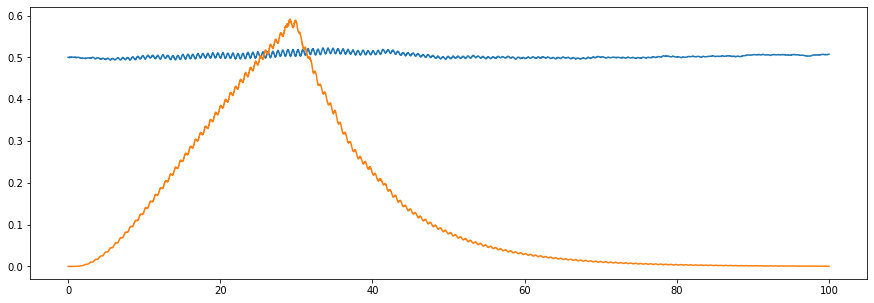

In [20]:
plt.figure(figsize=(15,5))
#plt.plot(time, x0)
#plt.plot(time, y0)
plt.plot(time, np.abs(z0))
plt.plot(time, np.abs(z2))
plt.show()

# Testing change_freq signal

[5.0203859 5.0203859 5.0203859 5.0203859]
[6.53798644 6.15188205]
[6.17286747 5.78676308] 2.425965411040039
[6.16793408 5.7818297 ] 2.425965411040039
[6.16296652 5.77686213] 2.425965411040039
[6.15796475 5.77186036] 2.425965411040039
[6.15292874 5.76682435] 2.425965411040039
[6.14785846 5.76175407] 2.425965411040039
[6.14275387 5.75664948] 2.425965411040039
[6.13761495 5.75151056] 2.425965411040039
[6.13244165 5.74633726] 2.425965411040039
[6.12723395 5.74112956] 2.425965411040039
[6.12199181 5.73588742] 2.425965411040039
[6.11671519 5.73061081] 2.425965411040046
[6.11140407 5.72529968] 2.425965411040039
[6.1060584  5.71995402] 2.425965411040039
[6.10067816 5.71457377] 2.425965411040039
[6.09526329 5.70915891] 2.425965411040039
[6.08981378 5.70370939] 2.425965411040039
[6.08432958 5.69822519] 2.425965411040039
[6.07881065 5.69270626] 2.425965411040039
[6.07325695 5.68715256] 2.425965411040039
[6.06766845 5.68156407] 2.425965411040039
[6.06204512 5.67594073] 2.425965411040039
[6.0563869

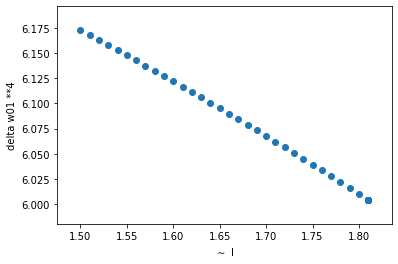

In [37]:
C = 5*10**(-14)
Ij = 40*e**3/hbar/C
L = 2 * 10**(-8)
M = 2 * 10**(-8)
#I = 1.72 * 10**(-8)


transmon = Transmon(psi = [1, 1, 0], C = C, Ij1 = Ij/2, Ij2 = Ij/2, M = M)
coupling = Coupling(C /100/2)
osc = Oscillator(psi = [1, 0, 0, 0, 0], L = L, C = C, gamma = 0.1, noise = 1)
drive_osc = InSignal()
dc_transmon = InSignal(change_freq = 1)

circuit = Circuit([transmon, coupling, osc, drive_osc, dc_transmon],\
                  [[1, 4], [0, 2], [1], [2], [0]],\
                  dt = dt)

print(circuit.elements[2].w / 2 / np.pi)
print(circuit.elements[0].w / 2 / np.pi)

change_freq_drive = np.arange(1.5, 1.81, 0.01) * 10**(-8)
circuit.upd_insignal(4, change_freq_drive)

arr = np.zeros(change_freq_drive.size + 10)

for i in range(0, change_freq_drive.size + 10):
    circuit = RK4(circuit)
    print(circuit.elements[0].w / 2 / np.pi, circuit.elements[0].w[0] - circuit.elements[0].w[1])
    arr[i] = (circuit.elements[0].w[0] / 2 / np.pi)
arr2 = np.append(change_freq_drive, np.array([change_freq_drive[-1]] * 10))*10**(8)

plt.scatter(arr2, arr)
plt.xlabel('$\sim$ I')
plt.ylabel('delta w01 **4')
plt.show()